In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from PIL import Image

# Class Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


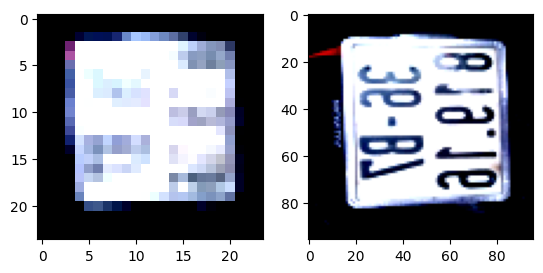

In [2]:
class LicensePlateDataset(Dataset):
    def __init__(self, LR_folder_path,HR_folder_path, width_lr, height_lr):
        super().__init__()
        self.LR_folder_path = LR_folder_path
        self.HR_folder_path = HR_folder_path
        #Resize low resolution image
        self.transforms_LR = transforms.Compose([
            transforms.Resize((width_lr,height_lr)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))
        ])
        #Resize high resolution image
        self.transforms_HR = transforms.Compose([
            transforms.Resize((width_lr*4,height_lr*4)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))
        ])
    def __len__(self):
        if os.listdir(self.LR_folder_path) != os.listdir(self.HR_folder_path):
            raise ValueError("HR image number is not same LR image number!")

        return len(os.listdir(self.LR_folder_path))

    def __getitem__(self, index):
        LR_tail = os.listdir(self.LR_folder_path)
        LR_image = Image.open(os.path.join(self.LR_folder_path,LR_tail[index]))
        LR_image = self.transforms_LR(LR_image)
        HR_tail = os.listdir(self.HR_folder_path)
        HR_image = Image.open(os.path.join(self.HR_folder_path,HR_tail[index]))
        HR_image = self.transforms_HR(HR_image)
        return (LR_image, HR_image)

# Path of image folder
LR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_no_augmentation\LR_data\LR_data"
HR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_no_augmentation\HR_data\HR_data"
Dataset = LicensePlateDataset(LR_path, HR_path, 24,24)

image_test1 = Dataset.__getitem__(1)[0]
image_test1 = image_test1.transpose(2,0)
image_test2 = Dataset.__getitem__(1)[1]
image_test2 = image_test2.transpose(2,0)
plt.subplot(1,2,1)
plt.imshow(image_test1)
plt.subplot(1,2,2)
plt.imshow(image_test2)
plt.show()

# Model

In [3]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        discriminator=False,
        use_act=True,
        use_bn=True,
        **kwargs,
    ):
        super().__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
            if discriminator
            else nn.PReLU(num_parameters=out_channels)
        )

    def forward(self, x):
        return self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False,
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_channels, 2), UpsampleBlock(num_channels, 2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = self.convblock(x) + initial
        x = self.upsamples(x)
        return torch.tanh(self.final(x))


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    discriminator=True,
                    use_act=True,
                    use_bn=False if idx == 0 else True,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

def test():
    low_resolution = 24  # 96x96 -> 24x24
    with torch.cuda.amp.autocast():
        x = torch.randn((5, 3, low_resolution, low_resolution))
        gen = Generator()
        gen_out = gen(x)
        disc = Discriminator()
        disc_out = disc(gen_out)

        print(gen_out.shape)
        print(disc_out.shape)
test()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


# Loss function

In [ ]:
# Hàm tính toán loss cho Generator
def generator_loss(fake_output, high_res_real, high_res_fake):
    adversarial_loss = loss_bce(fake_output, torch.ones_like(fake_output).to(device))
    content_loss = loss_mse(high_res_fake, high_res_real)
    return content_loss + 1e-3 * adversarial_loss

# Hàm tính toán loss cho Discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = loss_bce(real_output, torch.ones_like(real_output).to(device))
    fake_loss = loss_bce(fake_output, torch.zeros_like(fake_output).to(device))
    return real_loss + fake_loss

# Traing

In [ ]:

device = 'cuda'
# Giả sử đã có các lớp Generator và Discriminator
generator = Generator().to(device)
# generator.load_state_dict(torch.load('gen.pth'))
discriminator = Discriminator().to(device)
# discriminator.load_state_dict(torch.load('dis.pth'))

# Siêu tham số
epochs = 50
batch_size = 16
lr_generator = 1e-4
lr_discriminator = 1e-4

# Khởi tạo hàm tối ưu và hàm loss
optimizer_generator = Adam(generator.parameters(), lr=lr_generator, betas=(0.9, 0.999))
optimizer_discriminator = Adam(discriminator.parameters(), lr=lr_discriminator, betas=(0.9, 0.999))

loss_bce = nn.BCEWithLogitsLoss()
loss_mse = nn.MSELoss()

# Dataset và DataLoader
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize ảnh cho phù hợp
    transforms.ToTensor()
])

LR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_no_augmentation\LR_data\LR_data"
HR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_no_augmentation\HR_data\HR_data"
dataset = LicensePlateDataset(LR_path, HR_path, 16,16)
loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)

# Hàm huấn luyện một bước
def train_step(low_res, high_res_real):
    # Đưa dữ liệu vào thiết bị (GPU nếu có)
    low_res = low_res.to(device)
    high_res_real = high_res_real.to(device)


    # Huấn luyện Discriminator
    high_res_fake = generator(low_res)
    optimizer_discriminator.zero_grad()
    real_output = discriminator(high_res_real)
    fake_output = discriminator(high_res_fake.detach())  # Sử dụng detach để tránh cập nhật generator
    disc_loss = discriminator_loss(real_output, fake_output)
    disc_loss.backward()
    optimizer_discriminator.step()

    # Huấn luyện Generator
    optimizer_generator.zero_grad()
    fake_output = discriminator(high_res_fake)
    gen_loss = generator_loss(fake_output, high_res_real, high_res_fake)
    gen_loss.backward()
    optimizer_generator.step()

    return gen_loss.item(), disc_loss.item()

# Vòng lặp huấn luyện
for epoch in range(epochs):
    for low_res, high_res_real in loader:
        gen_loss, disc_loss = train_step(low_res, high_res_real)
    
    
    print(f"Epoch {epoch}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")


Epoch 0, Generator Loss: 0.14403730630874634, Discriminator Loss: 0.6854634284973145
Epoch 1, Generator Loss: 0.13932128250598907, Discriminator Loss: 0.0005046269507147372
Epoch 2, Generator Loss: 0.13921195268630981, Discriminator Loss: 1.5043120384216309
Epoch 3, Generator Loss: 0.15445229411125183, Discriminator Loss: 6.627679249504581e-05
Epoch 4, Generator Loss: 0.15212595462799072, Discriminator Loss: 3.2728788937674835e-05
Epoch 5, Generator Loss: 0.15162764489650726, Discriminator Loss: 2.9311611797311343e-05
Epoch 6, Generator Loss: 0.15187203884124756, Discriminator Loss: 2.7232159482082352e-05
Epoch 7, Generator Loss: 0.15145732462406158, Discriminator Loss: 2.5470579203101806e-05
Epoch 8, Generator Loss: 0.15167178213596344, Discriminator Loss: 2.396065065113362e-05
Epoch 9, Generator Loss: 0.15125443041324615, Discriminator Loss: 2.2675880245515145e-05
Epoch 10, Generator Loss: 0.1514764130115509, Discriminator Loss: 2.1536805434152484e-05
Epoch 11, Generator Loss: 0.1509

# Total parameters

In [16]:
total_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)+sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
total_params

25113284

In [5]:
torch.save(generator.state_dict(),'gen.pth')
torch.save(discriminator.state_dict(),'dis.pth')

# Evaluation(calculate PSNR, SSIM, NMSE)

In [6]:
import numpy as np
import cv2

def calculate_psnr(original, compressed):
    # Đảm bảo hai hình ảnh có cùng kích thước
    assert original.shape == compressed.shape, "Hình ảnh phải có cùng kích thước"

    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # PSNR vô cùng nếu không có sai khác

    max_pixel = 4.5  # Giả sử hình ảnh có độ sâu 8-bit
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def calculate_ssim(img1, img2):

    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tách các kênh màu (RGB)
    ssim_values = []
    for i in range(3):  # Duyệt qua 3 kênh màu
        ssim_value = ssim(img1[:, :, i], img2[:, :, i], data_range=img2[:, :, i].max() - img2[:, :, i].min())
        ssim_values.append(ssim_value)

    # Tính SSIM trung bình trên 3 kênh
    return np.mean(ssim_values)

import cv2
import numpy as np

def calculate_nmse(img1, img2):

    # Kiểm tra kích thước ảnh
    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tính NMSE
    numerator = np.sum((img1 - img2) ** 2)
    denominator = np.sum(img2 ** 2)
    nmse_value = numerator / denominator if denominator != 0 else float('inf')
    return nmse_value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


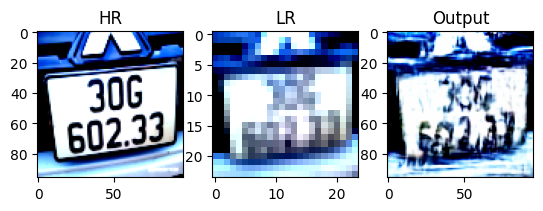

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


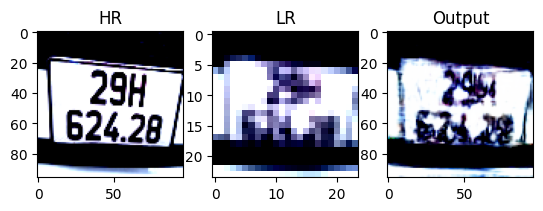

torch.Size([1, 3, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


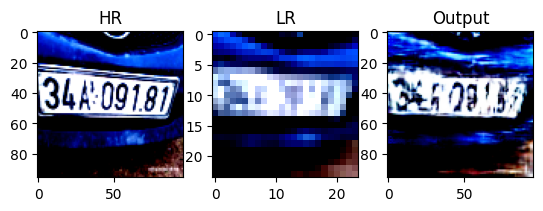

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


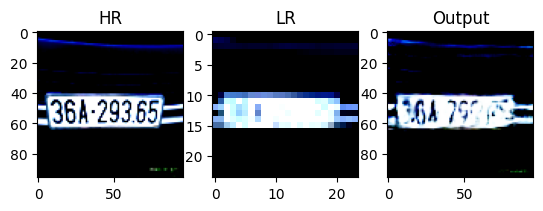

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


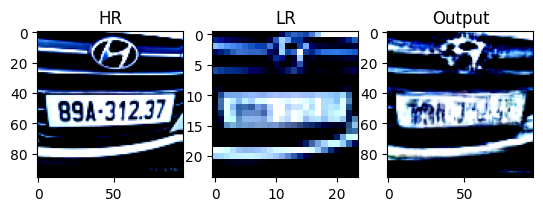

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


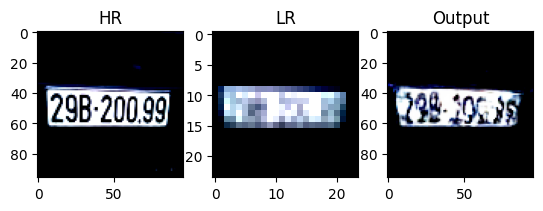

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


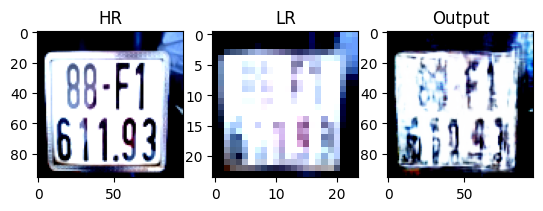

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


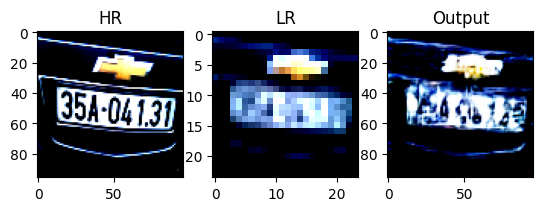

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


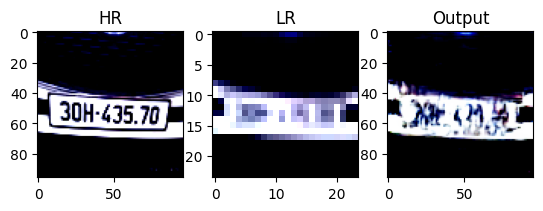

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


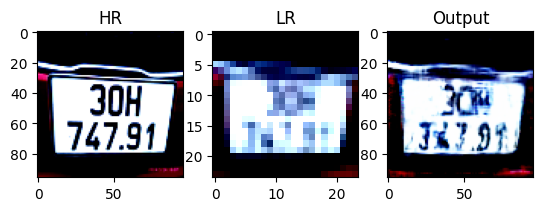

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


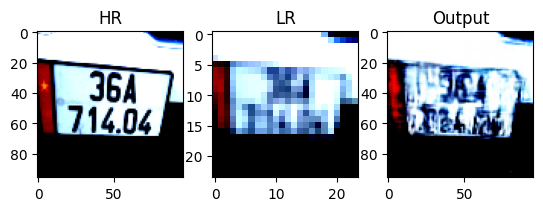

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


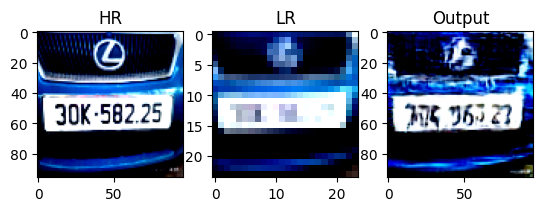

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


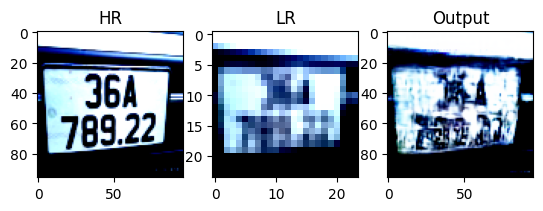

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


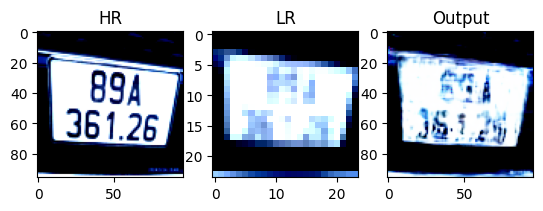

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


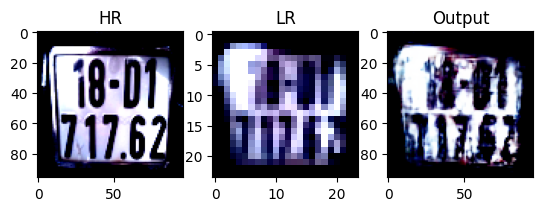

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


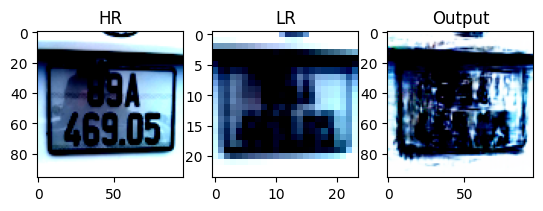

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


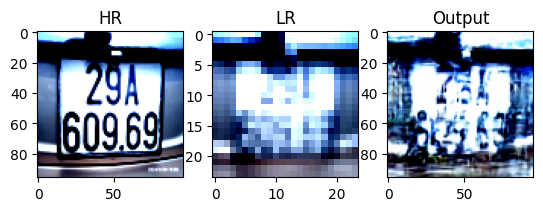

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


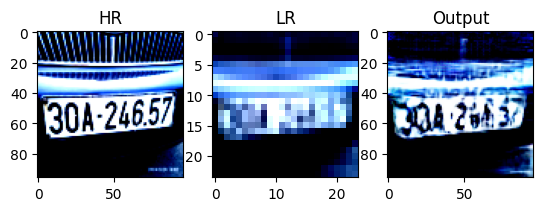

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


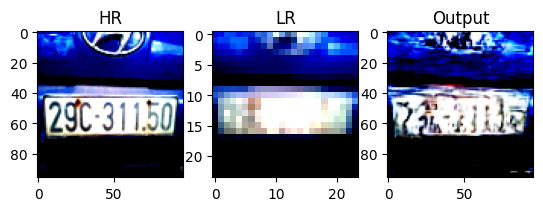

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


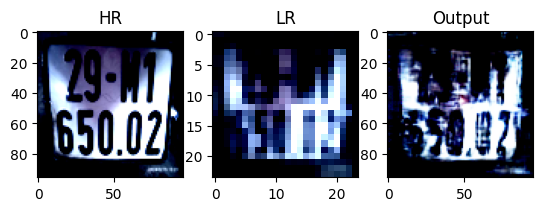

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


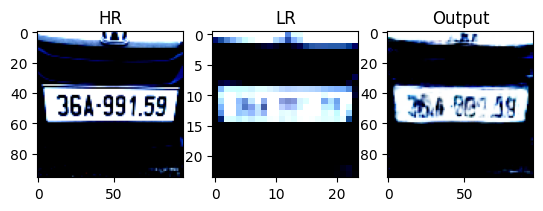

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


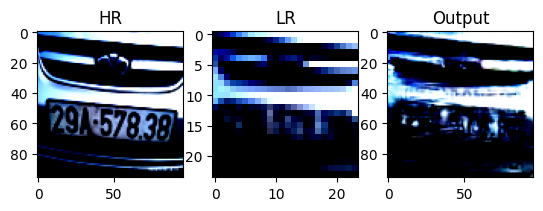

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


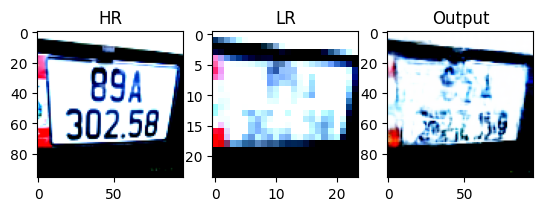

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


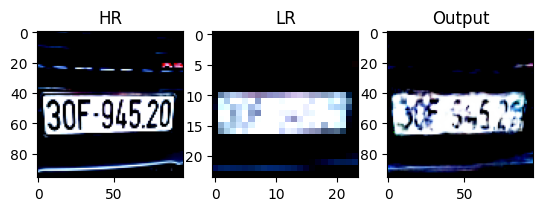

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


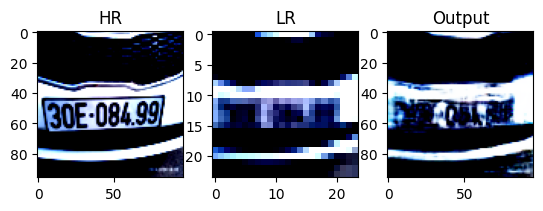

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


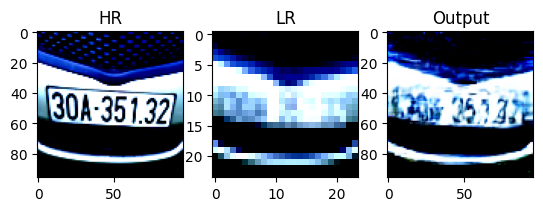

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


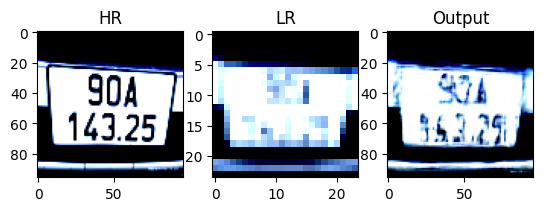

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


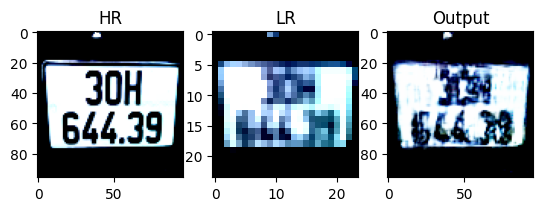

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


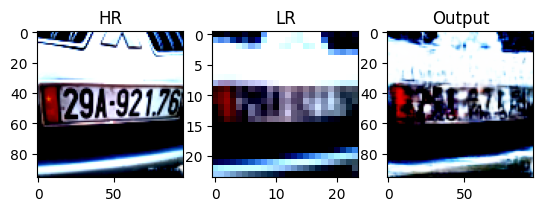

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])


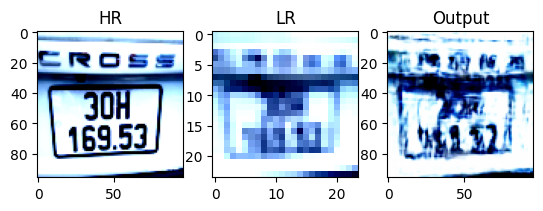

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 96, 96])



KeyboardInterrupt



In [5]:
image_dataset = LicensePlateDataset(LR_path, HR_path, 24,24)
loader = DataLoader(image_dataset, batch_size=1, shuffle=True)
for LR_image, HR_image in loader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = generator(LR_image)
        print(HR_output.shape)
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.cpu().detach().numpy()
        plt.subplot(1,3,1)
        plt.imshow(HR_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("HR")
        plt.subplot(1,3,2)
        plt.imshow(LR_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("LR")
        plt.subplot(1,3,3)
        plt.imshow(HR_output)
        plt.title("Output")
        plt.show()

In [8]:
import numpy as np
device = 'cuda'
psnr_score = []
ssim_score = []
nmse_score = []

for LR_image, HR_image in loader:

        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = generator(LR_image)
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.detach().cpu().numpy()

        HR_image = HR_image.squeeze(0).permute(1,2,0)
        HR_image = HR_image.detach().cpu().numpy()
        psnr_score.append(calculate_psnr(HR_image,HR_output))
        ssim_score.append(calculate_ssim(HR_image,HR_output))
        nmse_score.append(calculate_nmse(HR_image,HR_output))

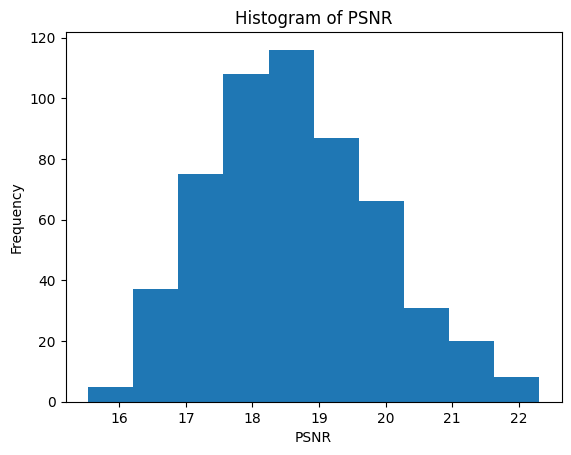

In [9]:
plt.hist(psnr_score)
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.title("Histogram of PSNR")
plt.show()

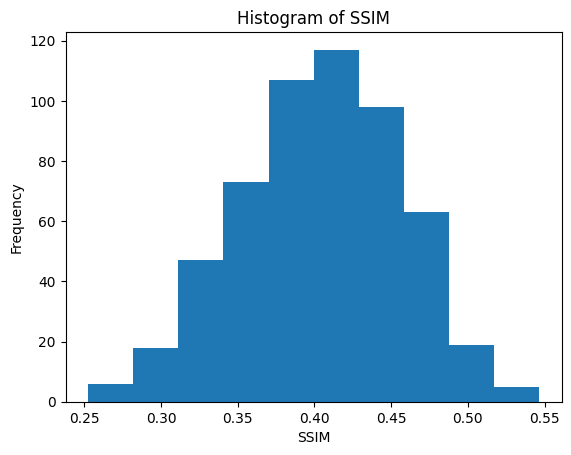

In [10]:
plt.hist(ssim_score)
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.title("Histogram of SSIM")
plt.show()

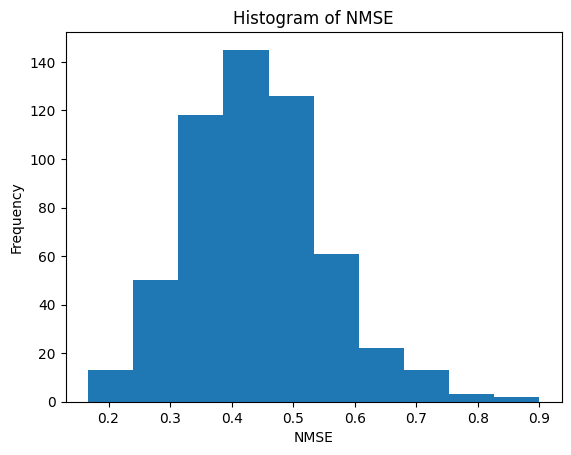

In [11]:
plt.hist(nmse_score)
plt.xlabel("NMSE")
plt.ylabel("Frequency")
plt.title("Histogram of NMSE")
plt.show()

In [12]:
import pandas as pd
GAN_dict = {"METHOD":"SRGAN","PSNR":psnr_score, "SSIM":ssim_score,"NMSE":nmse_score}
GAN_df = pd.DataFrame(GAN_dict)
GAN_df.head()

,METHOD,PSNR,SSIM,NMSE
0,SRGAN,18.479330,0.276136,0.429068
1,SRGAN,16.420302,0.357635,0.595676
2,SRGAN,19.410139,0.448551,0.350988
3,SRGAN,16.974074,0.383431,0.493400
4,SRGAN,16.986095,0.402427,0.601619


In [13]:
GAN_df.to_csv("GAN_df.csv")